#Text and Sequence Data Assignment

# Setup and Data Preprocessing

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load IMDB dataset
vocab_size = 10000
maxlen = 150
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)

# Pad sequences to fixed length
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

# Limit validation set to 10,000
x_val = x_val[:10000]
y_val = y_val[:10000]


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


- Imports all required libraries: TensorFlow/Keras for deep learning, NumPy for data, Matplotlib for plotting, pandas for dataframes.
- Sets random seeds to ensure consistent results each time.
- Loads the IMDB dataset with the top 10,000 most frequent words (for simplicity and speed).
- Pads all sequences (reviews) to a maximum length of 150 words using pad_sequences().
- Limits the validation set to the first 10,000 samples (as per assignment requirement).

 # Model Builders

In [ ]:
def build_model_with_embedding():
    model = keras.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
        layers.LSTM(64),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_pretrained_model(embedding_matrix, embedding_dim):
    model = keras.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                         weights=[embedding_matrix], input_length=maxlen,
                         trainable=False),
        layers.LSTM(64),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


- Defines two types of models:
 1. Trainable Embedding Model: Learns word meanings during training.
 2. Pretrained GloVe Model: Uses already-learned word meanings (from real-world texts) and freezes them.

Both models use:
* An embedding layer
* An LSTM (Recurrent Layer) for sequential understanding
* A Dense layer with sigmoid activation for binary classification (positive/negative)

#  Download and Load GloVe Embeddings

In [ ]:
# Download GloVe (only run once in Google Colab)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

# Load GloVe vectors
embedding_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

# Build embedding matrix for IMDB words
word_index = keras.datasets.imdb.get_word_index()
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < vocab_size:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec


--2025-04-15 03:42:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-15 03:42:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-15 03:42:45--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

* Downloads GloVe embeddings (100-dimensional) — trained on large real-world datasets.
* Reads the file and creates a dictionary (embedding_index) that maps each word to its vector.
* Converts the IMDB word indices to their GloVe vectors and builds a matching embedding matrix.
* This matrix will be loaded into the model to inject pretrained knowledge.

# Train Models with Varying Sample Sizes

In [ ]:
train_sizes = [100, 500, 1000, 5000]
results = []

for size in train_sizes:
    print(f"\n🔹 Training with {size} samples...")

    x_subset = x_train[:size]
    y_subset = y_train[:size]

    # Train model with trainable embedding
    model = build_model_with_embedding()
    history1 = model.fit(x_subset, y_subset, epochs=5, validation_data=(x_val, y_val), verbose=0)
    acc1 = history1.history['val_accuracy'][-1]
    results.append({'Train_Size': size, 'Embedding': 'Trainable', 'Val_Accuracy': acc1})

    # Train model with pretrained GloVe
    model = build_pretrained_model(embedding_matrix, embedding_dim)
    history2 = model.fit(x_subset, y_subset, epochs=5, validation_data=(x_val, y_val), verbose=0)
    acc2 = history2.history['val_accuracy'][-1]
    results.append({'Train_Size': size, 'Embedding': 'Pretrained', 'Val_Accuracy': acc2})



🔹 Training with 100 samples...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



🔹 Training with 500 samples...

🔹 Training with 1000 samples...

🔹 Training with 5000 samples...


* Trains both models for each training sample size (100, 500, 1000, 5000).
* For each size:
 - Trains the Trainable Embedding model
 - Trains the Pretrained GloVe model
 - Records the final validation accuracy for both
* Stores results in a list of dictionaries, which will later be converted into a table

# Results Table and Plot

   Train_Size   Embedding  Val_Accuracy
0         100   Trainable        0.5026
1         100  Pretrained        0.5038
2         500   Trainable        0.7178
3         500  Pretrained        0.5238
4        1000   Trainable        0.7058
5        1000  Pretrained        0.5492
6        5000   Trainable        0.7928
7        5000  Pretrained        0.6261


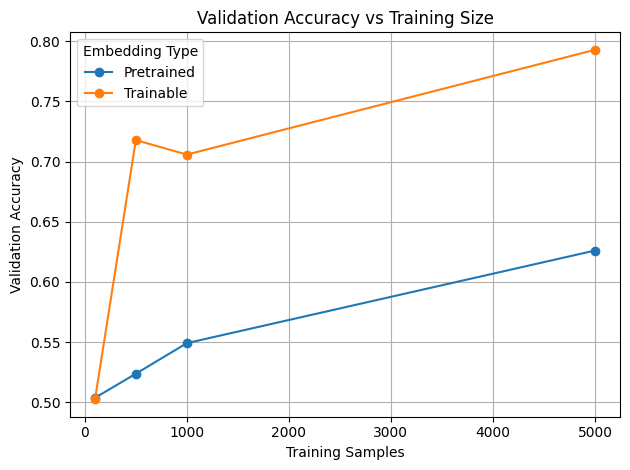

In [ ]:
# Convert to DataFrame
df_results = pd.DataFrame(results)
print(df_results)

# Pivot for plotting
pivot_df = df_results.pivot(index='Train_Size', columns='Embedding', values='Val_Accuracy')

# Plot
pivot_df.plot(marker='o')
plt.title("Validation Accuracy vs Training Size")
plt.ylabel("Validation Accuracy")
plt.xlabel("Training Samples")
plt.grid(True)
plt.legend(title="Embedding Type")
plt.tight_layout()
plt.show()


1. With very small training sets (100 samples):

- Both approaches perform similarly (about 50% accuracy)
- The pretrained embeddings have a tiny advantage (0.5038 vs 0.5026)


2. As training samples increase (500, 1000, 5000):

- The trainable embedding model quickly outperforms the pretrained model
- At 500 samples, the trainable model jumps to 71.78% while pretrained only reaches 52.38%
- This gap continues to widen with more samples


3. Contrary to what might be expected:

- The pretrained GloVe embeddings did not provide the advantage one might expect with limited data
- The trainable embeddings learned more effectively from the specific task data